# 라이브러리 

## 시계열

In [1]:
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import datetime
from datetime import datetime
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller

## 시각화

In [2]:
import matplotlib.pyplot as plt
plt.rc('font',family='Malgun Gothic')
import matplotlib as mpl

## 일반

In [3]:
import tensorflow as tf
from numpy import array
import pandas as pd
import numpy as np
import math
import urllib.request
import json
import os
import warnings
warnings.filterwarnings('ignore')

# 전체 농산물 데이터 2016.1.1 ~ 2020.11.4

In [4]:
train_df = pd.read_csv('nongsan_data/public_data/train.csv', encoding='utf-8',index_col='date',parse_dates=True)
test_df = pd.read_csv('nongsan_data/public_data/test_files/test_2020-11-05.csv', encoding='utf-8',index_col='date',parse_dates=True)

train_df = train_df[['배추_가격(원/kg)','요일']]
test_df = test_df[['배추_가격(원/kg)','요일']]

all_df = pd.concat([train_df,test_df],axis=0)

all_df = pd.get_dummies(all_df)
all_df.columns = ['배추가격','금','목','수','월','일','토','화']
all_df = all_df[['배추가격','월','화','수','목','금','토','일']]
all_df.tail()

,배추가격,월,화,수,목,금,토,일
date,,,,,,,,
2020-10-31,453.0,0,0,0,0,0,1,0
2020-11-01,0.0,0,0,0,0,0,0,1
2020-11-02,441.0,1,0,0,0,0,0,0
2020-11-03,478.0,0,1,0,0,0,0,0
2020-11-04,437.0,0,0,1,0,0,0,0


# 증강 디키 풀러 테스트

In [5]:
def adfuller_result(df):
    dftest = adfuller(df,autolag='AIC')
    dfout = pd.Series(dftest[0:4],index=['ADF_stat','p-value','num_lags','num_observations'])
    for key,val in dftest[4].items():
        dfout[f'critical_value {key}'] = val
        
    return dfout

In [6]:
# 배추 가격 데이터는 정상 데이터

adfuller_result(all_df['배추가격'])

ADF_stat                -4.371632
p-value                  0.000333
num_lags                23.000000
num_observations      1746.000000
critical_value 1%       -3.434101
critical_value 5%       -2.863197
critical_value 10%      -2.567652
dtype: float64

# 그래인저 인과성 테스트

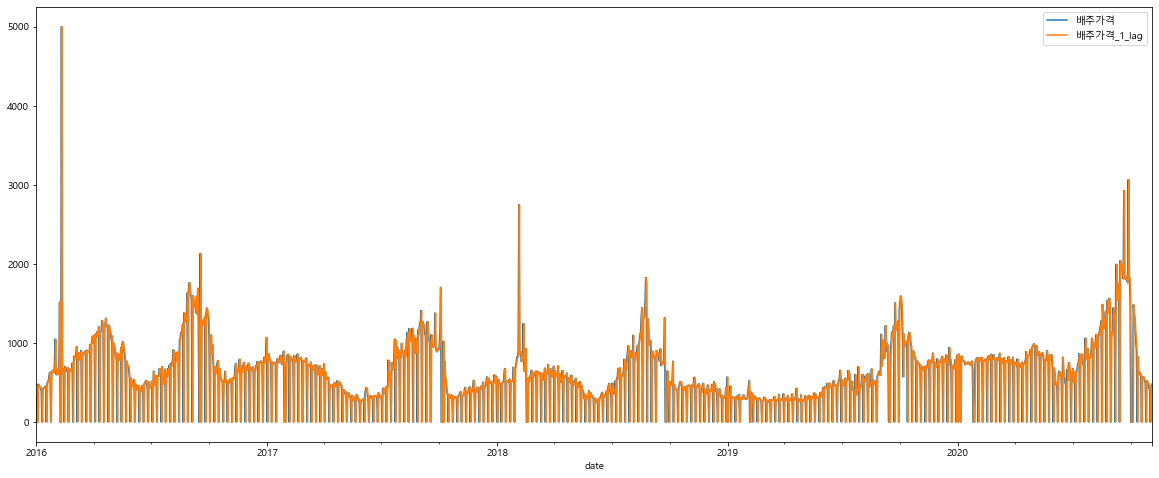

In [7]:
all_df['배추가격_1_lag'] = all_df['배추가격'].shift(1)
all_df[['배추가격','배추가격_1_lag']].plot(figsize=(20,8),legend=True);

In [8]:
from statsmodels.tsa.stattools import grangercausalitytests

grangercausalitytests(all_df.iloc[1:][['배추가격','배추가격_1_lag']],maxlag=5);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=153.3829, p=0.0000  , df_denom=1765, df_num=1
ssr based chi2 test:   chi2=153.6436, p=0.0000  , df=1
likelihood ratio test: chi2=147.3308, p=0.0000  , df=1
parameter F test:         F=153.3829, p=0.0000  , df_denom=1765, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=49.9015 , p=0.0000  , df_denom=1763, df_num=2
ssr based chi2 test:   chi2=100.0294, p=0.0000  , df=2
likelihood ratio test: chi2=97.3006 , p=0.0000  , df=2
parameter F test:         F=130.4165, p=0.0000  , df_denom=1763, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=10.3937 , p=0.0000  , df_denom=1761, df_num=3
ssr based chi2 test:   chi2=31.2697 , p=0.0000  , df=3
likelihood ratio test: chi2=30.9961 , p=0.0000  , df=3
parameter F test:         F=98.8773 , p=0.0000  , df_denom=1761, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.2539  , p=0.

# 계절성 시각화

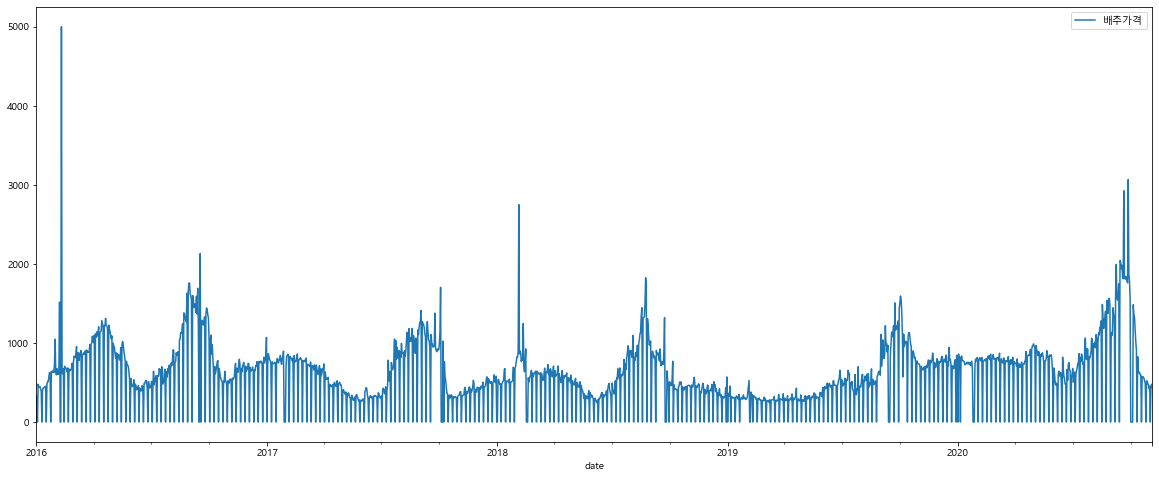

In [9]:
all_df['배추가격'].plot(figsize=(20,8),legend=True);

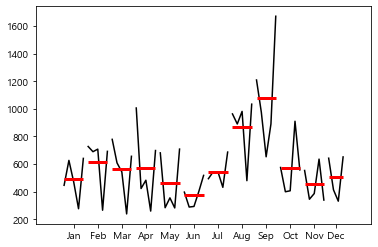

In [10]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

dfm = all_df['배추가격'].resample(rule='M').mean()

month_plot(dfm);

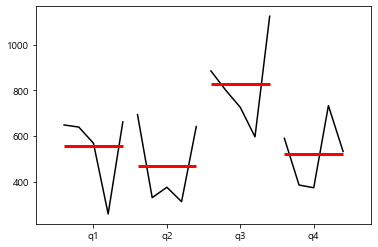

In [11]:
dfq = all_df['배추가격'].resample(rule='Q').mean()

quarter_plot(dfq);

In [12]:
all_df = all_df[['배추가격','월','화','수','목','금','토','일']]

In [13]:
#all_df['배추가격'] = all_df['배추가격'].replace(0,np.nan)
#all_df['배추가격'] = all_df['배추가격'].interpolate(method='spline',order=5).fillna(0)

In [14]:
all_df.tail()

,배추가격,월,화,수,목,금,토,일
date,,,,,,,,
2020-10-31,453.0,0,0,0,0,0,1,0
2020-11-01,0.0,0,0,0,0,0,0,1
2020-11-02,441.0,1,0,0,0,0,0,0
2020-11-03,478.0,0,1,0,0,0,0,0
2020-11-04,437.0,0,0,1,0,0,0,0


# 2016.1.1 ~ 2020.9.28 Train 데이터 

In [15]:
# train data set 불러오기

train_df = all_df.loc['2016-01-01':'2020-09-28']
train_df.head()

,배추가격,월,화,수,목,금,토,일
date,,,,,,,,
2016-01-01,0.0,0,0,0,0,1,0,0
2016-01-02,329.0,0,0,0,0,0,1,0
2016-01-03,0.0,0,0,0,0,0,0,1
2016-01-04,478.0,1,0,0,0,0,0,0
2016-01-05,442.0,0,1,0,0,0,0,0


# 2020.9.29 ~ 2020.11.4 Test 데이터 

In [16]:
test_df = all_df.loc['2020-09-29':'2020-11-04']
test_df.head()

,배추가격,월,화,수,목,금,토,일
date,,,,,,,,
2020-09-29,1787.0,0,1,0,0,0,0,0
2020-09-30,1551.0,0,0,1,0,0,0,0
2020-10-01,0.0,0,0,0,1,0,0,0
2020-10-02,0.0,0,0,0,0,1,0,0
2020-10-03,0.0,0,0,0,0,0,1,0


# pmd Arima

In [18]:
from pmdarima import auto_arima

exog_cabbage = auto_arima(train_df['배추가격'],seasonal=True,m=7,exogenous=train_df[['월','화','수','목','금','토','일']],trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=23898.720, Time=4.93 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=24847.060, Time=0.46 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=24287.219, Time=3.79 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=23797.386, Time=4.24 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=24844.924, Time=0.95 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=23926.153, Time=1.54 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=23922.882, Time=4.27 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=24005.204, Time=16.50 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=23782.311, Time=3.21 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=23954.058, Time=6.99 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=7.01 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=24686.655, Time=3.68 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=23795.701, Time=4.10 sec
 ARIMA(0,1,2)(1,0,0)[7] intercept   : AIC=23791.991, Time=3.93 sec
 ARIMA(1,1,2)(1,0,0)[7] 

In [19]:
exog_cabbage.to_dict()['order'],exog_cabbage.to_dict()['seasonal_order']

((0, 1, 1), (1, 0, 0, 7))

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

cabbage_exog_sarimax = SARIMAX(train_df['배추가격']
                               ,exog=train_df[['월','화','수','목','금','토','일']]
                               ,seasonal=True
                               ,order=(0,1,1)
                               ,seasonal_order=(1,0,0,7)
                               ,enforce_invertibility=False)

In [21]:
fitted_sarimax = cabbage_exog_sarimax.fit()

In [22]:
exog_prediction = fitted_sarimax.predict(len(train_df),len(all_df)-1,exog=test_df[['월','화','수','목','금','토','일']]).rename('SARIMAX_EXOG')

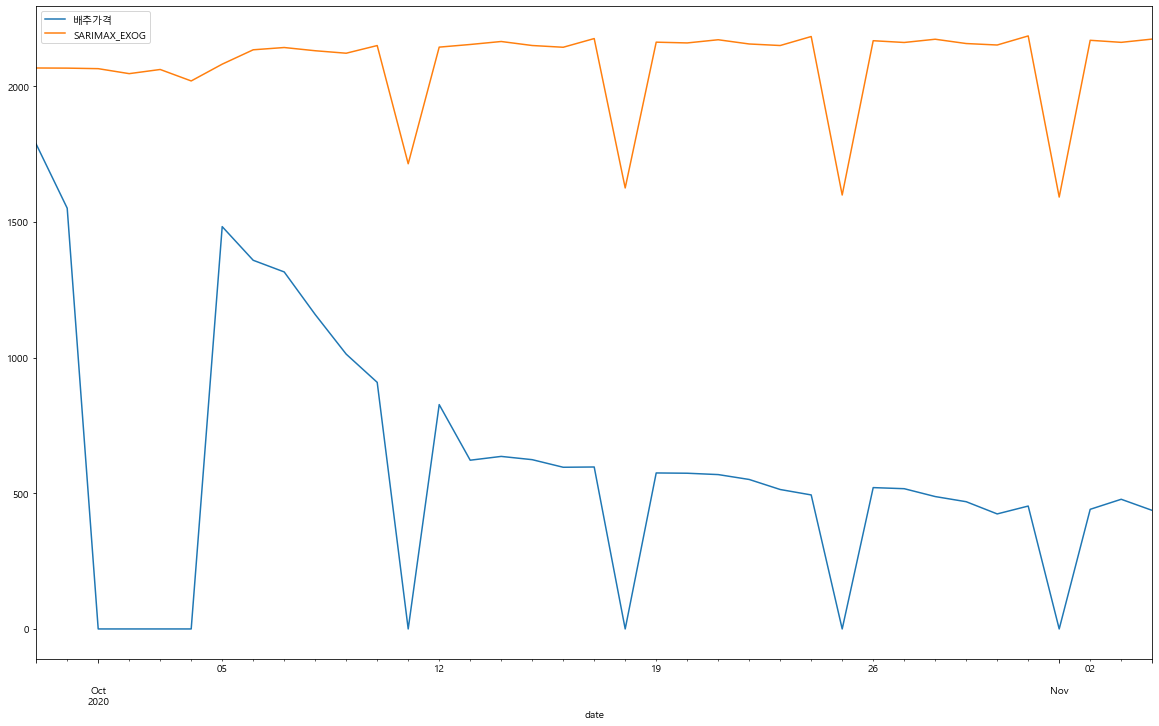

In [23]:
test_df['배추가격'].plot(figsize=(20,12),legend=True);
exog_prediction.plot(legend=True);

In [24]:
from statsmodels.tools.eval_measures import rmse

rmse(test_df['배추가격'],exog_prediction)

1546.4129831631192

# 생각해볼 추가 변수

공휴일, 대체 공휴일, 달